In [49]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import to_rgba
from urllib.request import urlopen
from mplsoccer import Pitch, FontManager, VerticalPitch, add_image
from PIL import Image

from matplotlib.patches import FancyArrowPatch

Carga de dataframe

In [5]:
partido=pd.read_csv('gevpsitas2.csv')

# Convertir las columnas a tipo numérico
partido['Player'] = partido['Player'].str.strip()
partido['Y'] = pd.to_numeric(partido['Y'], errors='coerce')
partido['X2'] = pd.to_numeric(partido['X2'], errors='coerce')
partido['Y2'] = pd.to_numeric(partido['Y2'], errors='coerce')

# Definir los valores mínimos y máximos de X en ambas escalas
x1, x2 = 0, 100  # Escala original de X
new_x1, new_x2 = 0, 28  # Nueva escala de X

# Definir los valores mínimos y máximos de Y en ambas escalas
y1, y2 = 0, 100  # Escala original de Y
new_y1, new_y2 = 16, 0  # Nueva escala de Y

# Calcular la coordenada transformada de Y y sobrescribir la columna 'Y' con el resultado
partido['Y'] = ((new_y2 - new_y1) / (y2 - y1)) * partido['Y']*-1
partido['Y2'] = ((new_y2 - new_y1) / (y2 - y1)) * partido['Y2']*-1
# Calcular la coordenada transformada de X y sobrescribir la columna 'X' con el resultado
partido['X'] = ((new_x2 - new_x1) / (x2 - x1)) * partido['X'] 
partido['X2'] = ((new_x2 - new_x1) / (x2 - x1)) * partido['X2'] 

print(partido.head())

    Team Player Event  Mins  Secs      X      Y     X2     Y2  id
0  SITAS      2  Pase    27     5   3.08  11.20   7.84   3.36   1
1  SITAS      4  Pase    27     7   7.56   2.72   8.12   7.52   2
2  SITAS     10  Pase    27     8   8.68   7.84   8.12  14.56   3
3  SITAS      2  Pase    27    10   6.16  15.04  17.08   9.92   4
4  SITAS     11  Pase    27    12  17.36  11.04  14.28   7.84   5


In [25]:
def generar_mapa_pases(pases_comp, minuto_inicial, minuto_final, ax):
    completados = pases_comp[(pases_comp['Mins'] >= minuto_inicial) & (pases_comp['Mins'] < minuto_final)]
    average_locations = completados.groupby('Player').agg({'Y': ['mean'], 'X': ['mean', 'count']})
    pass_between = completados.groupby(['pasador', 'receptor']).id.count().reset_index()
    pass_between.rename({'id': 'pass_count'}, axis='columns',inplace=True)
    average_locations.columns = average_locations.columns.droplevel(0)
    average_locations['Y'] = average_locations.iloc[:, 0]
    average_locations['X'] = average_locations.iloc[:, 1]
    average_locations = average_locations.drop(columns=['mean'])
    pass_between = pass_between.merge(average_locations, left_on='pasador', right_index=True)
    pass_between = pass_between.merge(average_locations, left_on='receptor', right_index=True, suffixes=['','_end'])
    pass_between = pass_between[pass_between['pass_count'] >= 1]
    MAX_LINE_WIDTH = 13
    pass_between['width'] = (pass_between.pass_count / pass_between.pass_count.max() * MAX_LINE_WIDTH)

    MIN_TRANSPARENCY = 0.000001
    color = np.array(to_rgba('green'))
    color = np.tile(color, (len(pass_between), 1))
    c_transparency = pass_between.pass_count / pass_between.pass_count.max()
    c_transparency = (c_transparency * (1 - MIN_TRANSPARENCY)) + MIN_TRANSPARENCY
    color[:, 3] = c_transparency

    MAX_MARKER_SIZE=400
    average_locations['marker_size'] = (average_locations['count'] / average_locations['count'].max() * MAX_MARKER_SIZE)
   
    pitch=Pitch()
   # Definir las dimensiones del campo
    ancho = 16
    alto = 28

    
    # Dibujar el rectángulo del campo (fondo naranja)
    ax.add_patch(plt.Rectangle((0, 0), ancho, alto, fill=True, color='orange', alpha=0.8))

    # Dibujar las líneas de la cancha
    ax.plot([0, ancho], [0, 0], color='black', linewidth=2)  # Línea de fondo
    ax.plot([0, ancho], [alto, alto], color='black', linewidth=2)  # Otra línea de fondo
    ax.plot([0, ancho], [alto/2, alto/2], color='black', linewidth=1)  # Línea central
    ax.plot([0, 0], [0, alto], color='black', linewidth=2)  # Línea lateral izquierda
    ax.plot([ancho, ancho], [0, alto], color='black', linewidth=3)  # Línea lateral derecha


    # Dibujar lineas de penal

    ax.plot( [7.5, 8.5],[ (alto /2)*1.33,  (alto /2)*1.33], color='white', linewidth=2)  # Línea penal
    ax.plot( [7.5, 8.5],[ (alto /2)*0.66,  (alto/2 )*0.66], color='white', linewidth=2)  # Línea penal

    #Aros

    ax.add_patch(plt.Circle((ancho/2 , (alto /2)*1.66), radius=0.5, fill=False, color='red', linewidth=2))
    ax.add_patch(plt.Circle((ancho/2 , (alto/2 )*0.33), radius=0.5, fill=False, color='red', linewidth=2))

    #Circulo de rebote

    ax.add_patch(plt.Circle((ancho/2 , (alto /2)*1.66), radius=2, fill=False, color='white', linewidth=2, linestyle='--'))
    ax.add_patch(plt.Circle((ancho/2 , (alto/2 )*0.33), radius=2, fill=False, color='white', linewidth=2, linestyle='--'))


    # Configurar los ejes
    ax.set_xlim(0, ancho)
    ax.set_ylim(0, alto)
    ax.set_aspect('equal')
    plt.axis('off')  # Ocultar ejes

    arrows = pitch.arrows(pass_between.Y, pass_between.X, pass_between.Y_end, pass_between.X_end, ax=ax, color=color, zorder=1)

    nodes = pitch.scatter(average_locations.Y, average_locations.X, ax=ax, color='white', ec='black', s=average_locations['marker_size'])
    
    for index, row in pass_between[['pasador', 'Y', 'X']].drop_duplicates(subset='pasador').iterrows():
        pitch.annotate(row.pasador.split(' ')[-1], xy=(row.Y, row.X), c='black', va='center',
                       ha='center', size=11, weight='bold', ax=ax,zorder=1)

    TITLE_TEXT = f'Min {minuto_inicial}-{minuto_final}'
    ax.text(0, 30, TITLE_TEXT, color='#c7d5cc', va='center', ha='center', fontsize=18)

In [28]:
partido['pasador'] = partido['Player']
partido['receptor'] = partido['Player'].shift(-1)
pases_partido = partido[(partido['Event'] == 'Pase') & (partido['Team'] == 'GEVP')]

completados_tot = pases_partido

completados_tot

,Team,Player,Event,Mins,Secs,X,Y,X2,Y2,id,pasador,receptor
9,GEVP,12,Pase,27,18,15.40,12.80,9.80,14.88,10,12,11
10,GEVP,11,Pase,27,21,8.68,14.24,4.20,9.92,11,11,5
19,GEVP,5,Pase,27,39,14.56,5.44,8.96,2.08,20,5,11
20,GEVP,11,Pase,27,40,10.08,2.24,6.16,4.80,21,11,5
21,GEVP,5,Pase,27,42,3.64,2.24,9.24,2.40,22,5,2
...,...,...,...,...,...,...,...,...,...,...,...,...
679,GEVP,11,Pase,53,53,10.08,13.76,5.60,12.00,680,11,8
680,GEVP,8,Pase,53,55,6.16,10.24,11.48,6.88,681,8,2
681,GEVP,2,Pase,53,56,12.04,6.24,9.52,13.60,682,2,11
682,GEVP,11,Pase,53,57,9.52,14.24,5.60,9.28,683,11,5


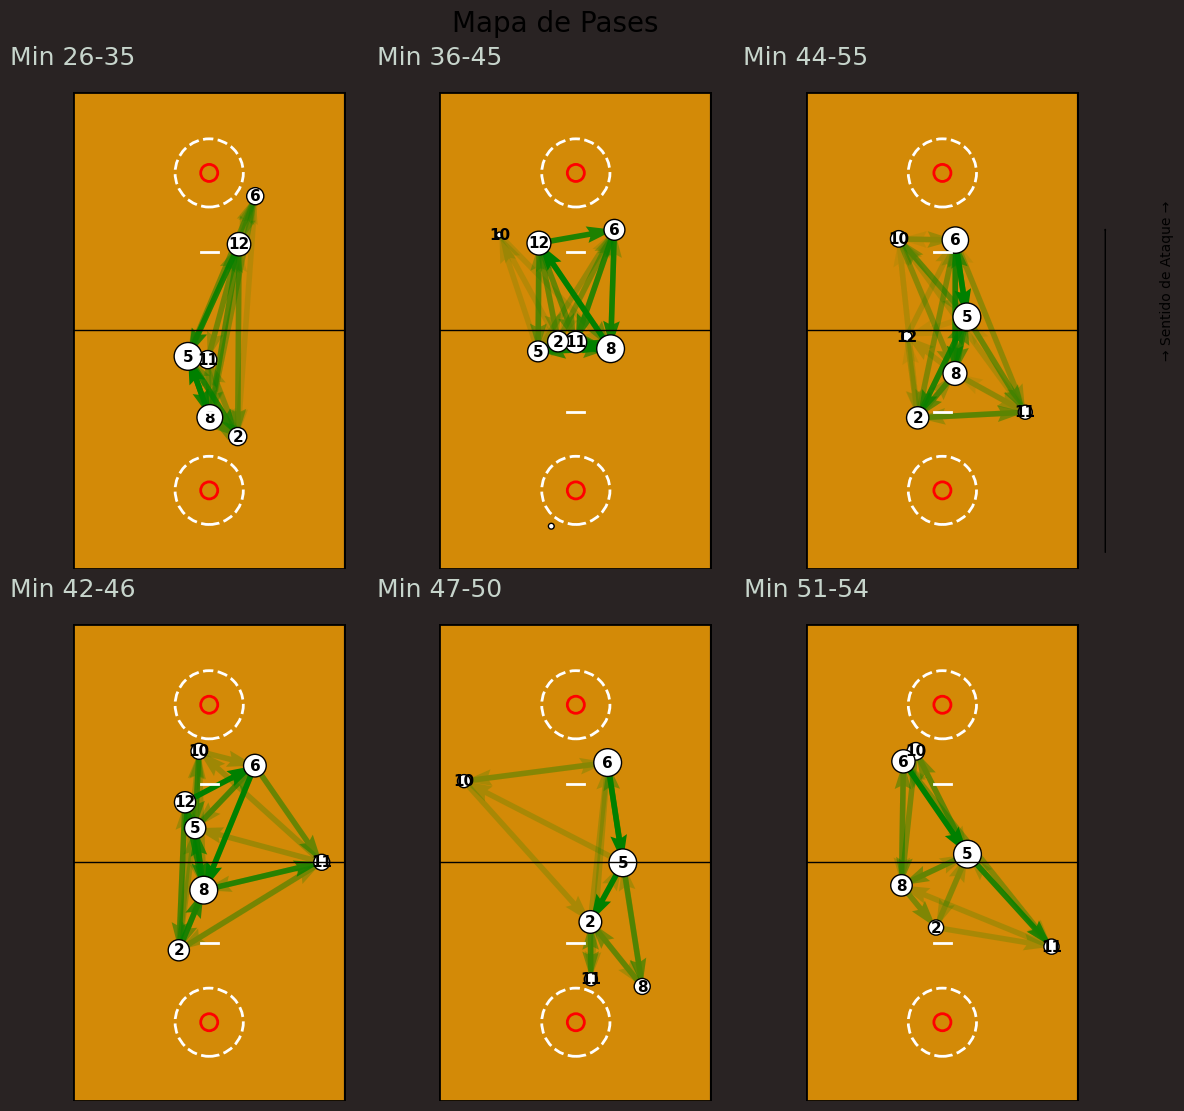

In [58]:
fig = plt.figure(figsize=(11,11),constrained_layout=True)
# Agregar un título a la figura
fig.suptitle('Mapa de Pases', fontsize=20)
# Definir las coordenadas de la flecha y el texto
arrow_coords = (1, 0.5), (1, 0.8)  # Coordenadas para la flecha

# Agregar una flecha hacia arriba
arrow = FancyArrowPatch(*arrow_coords, arrowstyle='->', color='Black')
fig.add_artist(arrow)

gs = fig.add_gridspec(nrows=6,ncols=6)
fig.set_facecolor('#292323')

ax1 = fig.add_subplot(gs[0:3,0:2])
generar_mapa_pases(completados_tot, 26, 35, ax1)

ax2 = fig.add_subplot(gs[0:3,2:4])
generar_mapa_pases(completados_tot, 36, 45, ax2)
fig.text(1.05, 0.75, '→ Sentido de Ataque →', rotation=90, va='center', ha='left')

ax3 = fig.add_subplot(gs[0:3,4:])
generar_mapa_pases(completados_tot, 44, 55, ax3)


ax4 = fig.add_subplot(gs[3:,0:2])
generar_mapa_pases(completados_tot, 42, 46, ax4)


ax5 = fig.add_subplot(gs[3:,2:4])
generar_mapa_pases(completados_tot, 47, 50, ax5)


ax6 = fig.add_subplot(gs[3:,4:])
generar_mapa_pases(completados_tot, 51, 54, ax6)
